# AI for cell recognition

To help physicians we need to develop an AI that can classify cells into different types. For that, we have opened huge slide images, detected many cells, and extracted a feature vector for each of them.

We also have asked the experts to annotate, for each cell class and many examples, if the cell belongs or not to the given class. Our data is organized as follows:
- `annotations_{class}.csv` are CSVs for the three classes of interest, namely `(lymphocyte, lymphoplasmocyte, plasmocyte)`. The first column represents the cell index and the second a binary value (1 if the cell belongs to the class, else 0). 
- `cell_dataset.pkl` is the file containing the features and bounding boxes for the cells. We will not use the bounding boxes for now, they will be used later for visualization purposes. 

We now load the data and print some things:

In [1]:
import pickle
import csv

# load features
with open('cell_dataset.pkl', 'rb') as f:
    features = pickle.load(f)['feats']
print('features is a matrix of dimension (N,D)=', features.shape)

# load annotations for all classes
classes = ("lymphocyte", "lymphoplasmocyte", "plasmocyte")
annotations = {c: ([], []) for c in classes}  # init empty dict per class
for i, c in enumerate(classes):
    print("-"*80)
    print('class', i, 'is', c)
    annotation_file = f"annotations_{c}.csv"
    # load annotation file
    with open(annotation_file, 'r') as f:
        reader = csv.reader(f)
        # skip header
        for row in reader:
            annotations[c][0].append(int(row[0]))  # cell index
            annotations[c][1].append(bool(int(row[1])))  # is positive?
    print("number of annotations for class", c, "is", len(annotations[c][0]))
    print("number of positive annotations for class", c, "is", sum(annotations[c][1]))
         

features is a matrix of dimension (N,D)= (984007, 384)
--------------------------------------------------------------------------------
class 0 is lymphocyte
number of annotations for class lymphocyte is 551
number of positive annotations for class lymphocyte is 255
--------------------------------------------------------------------------------
class 1 is lymphoplasmocyte
number of annotations for class lymphoplasmocyte is 468
number of positive annotations for class lymphoplasmocyte is 138
--------------------------------------------------------------------------------
class 2 is plasmocyte
number of annotations for class plasmocyte is 484
number of positive annotations for class plasmocyte is 134


## Reformatting the data
We can see that, contrary to how most multi-class classification problems are organized, our annotations are binary for each class. However, we would like to use common techniques on multi-class classification, so it would be nice to convert our dataset to the standard format.

What is this format? Well, it is defined by two variables `X` and `y`. The matrix `X` is of shape `(A,D)`, where `A` is the total number of annotations and `D` the feature dimension. `X` contains real values. The vector `y` has shape `D`, and contains integers, one representing each class. Note that we have a total of 4 classes `(0,1,2,3)`, because we have the three cell types + the class of cells that are not any of these three types.

### Task 1: Consistency
We need to check that the data is of good quality. For that, check that the annotations are consistent: this is, check that all the annotations refer to different indices. If there are annotations for the same index, then the annotation should not be contradictory. Each annotation should belong to only one class.

If there are any indices that were inconsistently annotated, print them out. 

### Task 2: Formatting
Now that we have ensured consistency, we need to format the labels or annotations in variables `X,y` as described above. For that, create a list of annotated indices, the list of corresponding labels (0,1,2, or 3) and the list of features corresponding to the indices.

In [2]:
# Initialiser un dictionnaire pour stocker les annotations de toutes les classes par index
combined_annotations = {}

# Liste pour stocker toutes les incohérences
inconsistent_indices = []

# Fusionner les annotations pour chaque classe
for c in classes:
    indices = annotations[c][0]
    labels = annotations[c][1]
    for idx, label in zip(indices, labels):
        if idx not in combined_annotations:
            combined_annotations[idx] = {c: label}
        else:
            if c in combined_annotations[idx] and combined_annotations[idx][c] != label:
                # Ajouter l'incohérence au tableau des incohérences
                inconsistent_indices.append({
                    'index': idx,
                    'class': c,
                    'existing_label': combined_annotations[idx][c],
                    'new_label': label,
                    'type': 'incoherent'
                })
        combined_annotations[idx][c] = label

# Détecter les indices ayant plusieurs classes
for idx, class_labels in combined_annotations.items():
    # Vérifier si l'index appartient à plus d'une classe (labels True pour plusieurs classes)
    positive_classes = [class_name for class_name, label in class_labels.items() if label]
    if len(positive_classes) > 1:
        # Ajouter l'indice avec plusieurs classes au tableau des incohérences
        inconsistent_indices.append({
            'index': idx,
            'classes': positive_classes,
            'type': 'multiple_classes'
        })

# Afficher les incohérences
print("Indices incohérents ou ayant plusieurs classes :")
for inconsistency in inconsistent_indices:
    if inconsistency['type'] == 'incoherent':
        print(f"Index {inconsistency['index']} a une incohérence entre les classes {inconsistency['class']} : "
              f"ancienne étiquette = {inconsistency['existing_label']}, nouvelle étiquette = {inconsistency['new_label']}")
    elif inconsistency['type'] == 'multiple_classes':
        print(f"Index {inconsistency['index']} appartient aux classes : {inconsistency['classes']}")

# Résumé
if not inconsistent_indices:
    print("Aucune incohérence détectée.")
else:
    print(f"\nNombre total d'incohérences ou d'indices ayant plusieurs classes : {len(inconsistent_indices)}")


Indices incohérents ou ayant plusieurs classes :
Index 585154 a une incohérence entre les classes lymphocyte : ancienne étiquette = False, nouvelle étiquette = True
Index 732406 a une incohérence entre les classes lymphoplasmocyte : ancienne étiquette = True, nouvelle étiquette = False
Index 968583 a une incohérence entre les classes plasmocyte : ancienne étiquette = True, nouvelle étiquette = False
Index 729897 appartient aux classes : ['lymphoplasmocyte', 'plasmocyte']

Nombre total d'incohérences ou d'indices ayant plusieurs classes : 4


### Remove incoherent/inconsistent annotations 

In [3]:
inconsistent_indices_list = [inconsistency['index'] for inconsistency in inconsistent_indices]
filtered_combined_annotations = {ann_key: ann_value for ann_key, ann_value in combined_annotations.items() if ann_key not in inconsistent_indices_list}
# print(len(combined_annotations), len(filtered_combined_annotations))

final_annotations = ([], [])
for idx, class_labels in filtered_combined_annotations.items():
    assigned = False
    for class_name, label in class_labels.items():
        if label:
            if assigned:
                raise ValueError(f"Index {idx} has multiple positive classes.")
            final_annotations[0].append(idx)
            final_annotations[1].append(classes.index(class_name))
            assigned = True 
    if not assigned:
        final_annotations[0].append(idx)
        final_annotations[1].append(len(classes))
    print(final_annotations[0][-1], final_annotations[1][-1])

258953 2
341847 2
341849 2
341393 2
338490 2
335594 2
334475 2
590235 0
590663 0
591123 0
591121 0
591125 0
591572 0
592048 0
591577 0
592934 0
594317 0
595206 0
596230 0
597324 0
597820 0
599477 0
601582 0
602509 0
602507 0
601593 0
602512 0
602511 0
602529 0
603451 0
604364 0
604367 0
603463 0
603459 0
603460 0
605445 0
602548 0
603479 0
603481 0
705481 0
705986 0
705485 0
706450 0
705992 0
706977 0
707449 0
708918 0
710329 0
711608 0
712958 0
714534 0
693830 0
694615 0
694620 0
695494 0
694604 0
697923 0
697921 0
698587 0
698588 0
588227 0
588636 0
589443 0
587766 1
589029 1
593407 2
596775 2
708401 2
709365 2
693824 2
693836 2
697138 2
698589 2
699862 2
703355 2
598341 3
598344 3
598339 3
598340 3
598901 3
598898 3
598902 3
598900 3
598899 3
599478 3
599479 3
599480 3
600794 3
600793 3
600790 3
601585 3
600795 3
601595 3
600791 3
601588 3
601596 3
601584 3
601590 3
602504 3
601587 3
601592 3
601594 3
602502 3
602505 3
602506 3
602513 3
601601 3
601600 3
601599 3
602514 3
601605 3
6

### Save the final annotations

In [4]:
import numpy as np
clean_annotations = np.array(final_annotations)  # (2, A), (indices, labels) 
np.save('clean_annotations.npy', clean_annotations)

## Create the labeled and unlabeled datasets

In [5]:
with open('cell_dataset.pkl', 'rb') as f:
    all_data = pickle.load(f)

all_features = all_data['feats']  # (N, D)
annotation_indices = clean_annotations[0]
labels = clean_annotations[1]

labeled_features = all_features[annotation_indices]
labeled_bboxes = all_data["bboxes"][annotation_indices]

unlabeled_mask = ~np.isin(np.arange(len(all_features)), annotation_indices)
unlabeled_features = all_features[unlabeled_mask]

np.save('X_labeled.npy', labeled_features)
np.save('y_labeled.npy', labels)
np.save('X_unlabeled.npy', unlabeled_features)
np.save('labeled_bboxes.npy', labeled_bboxes)



# Visualize images

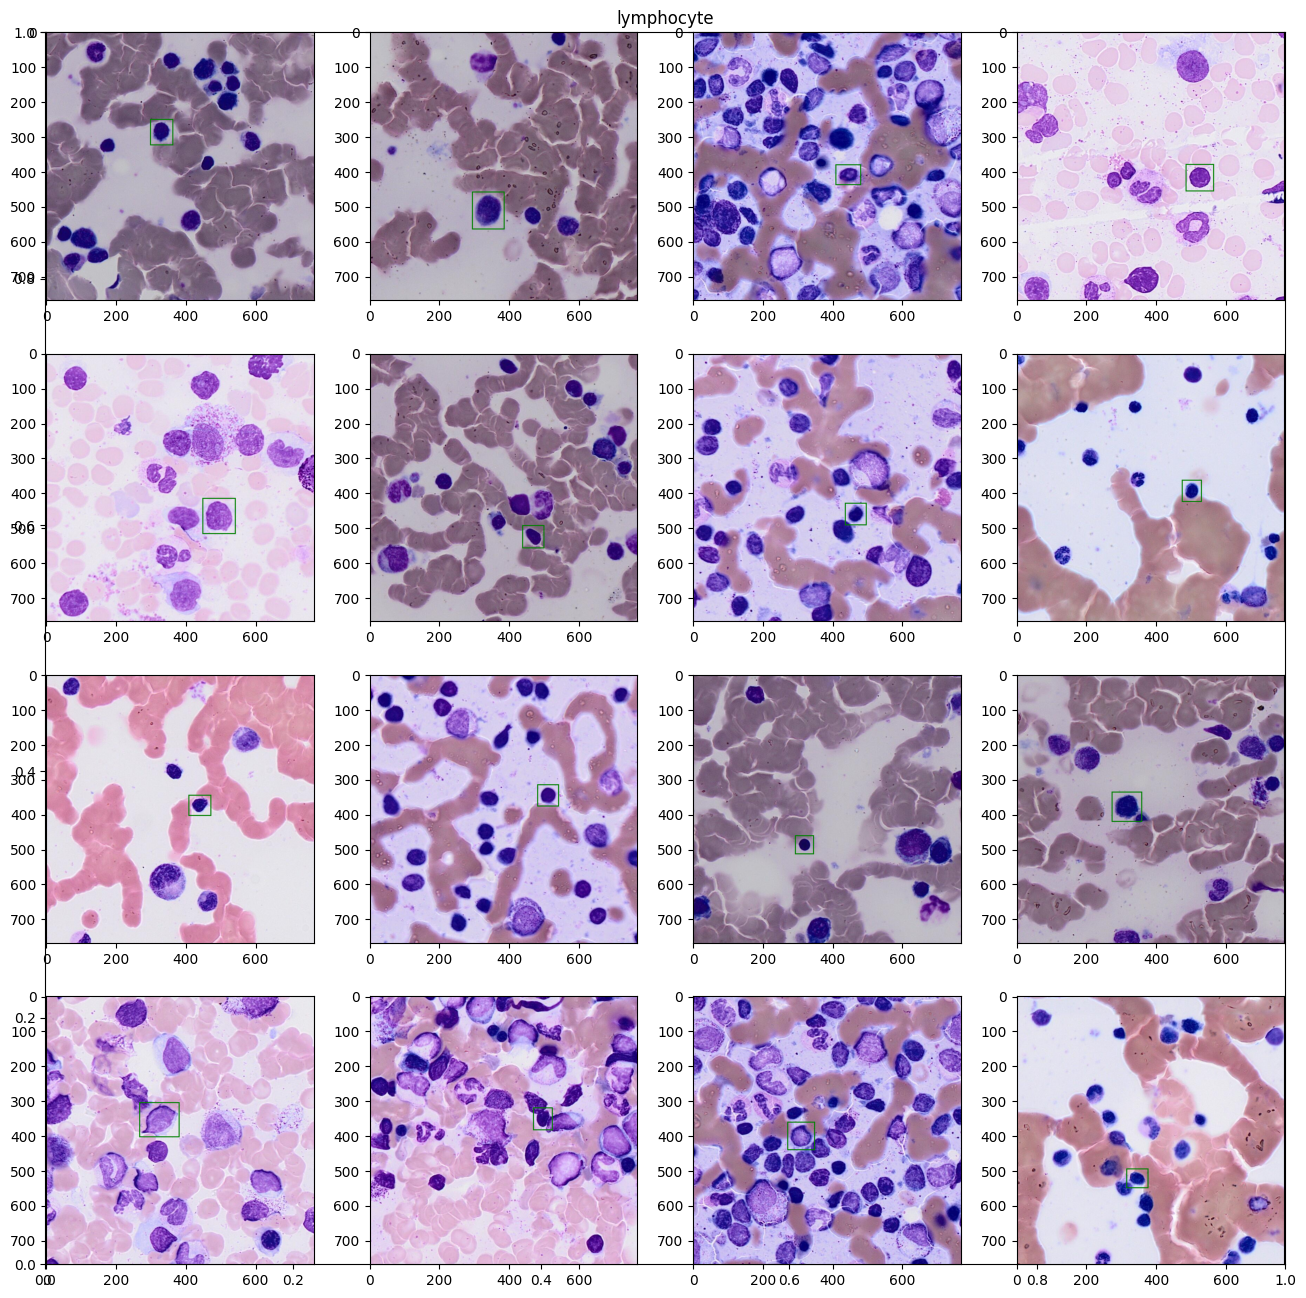

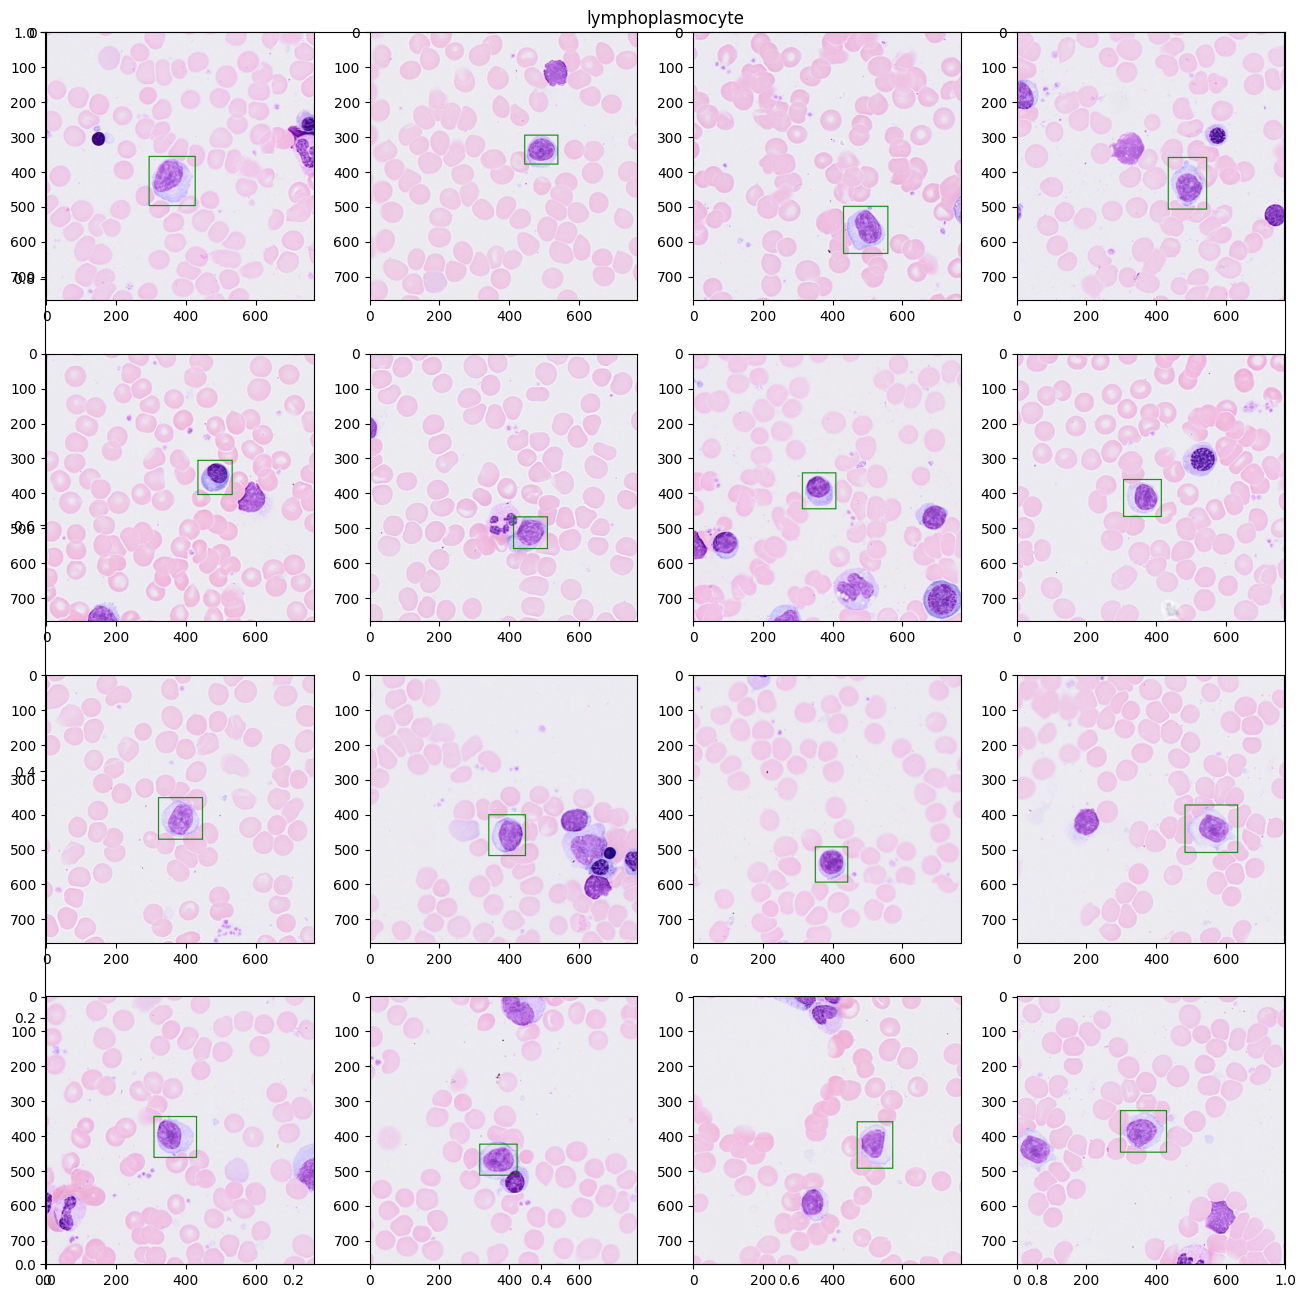

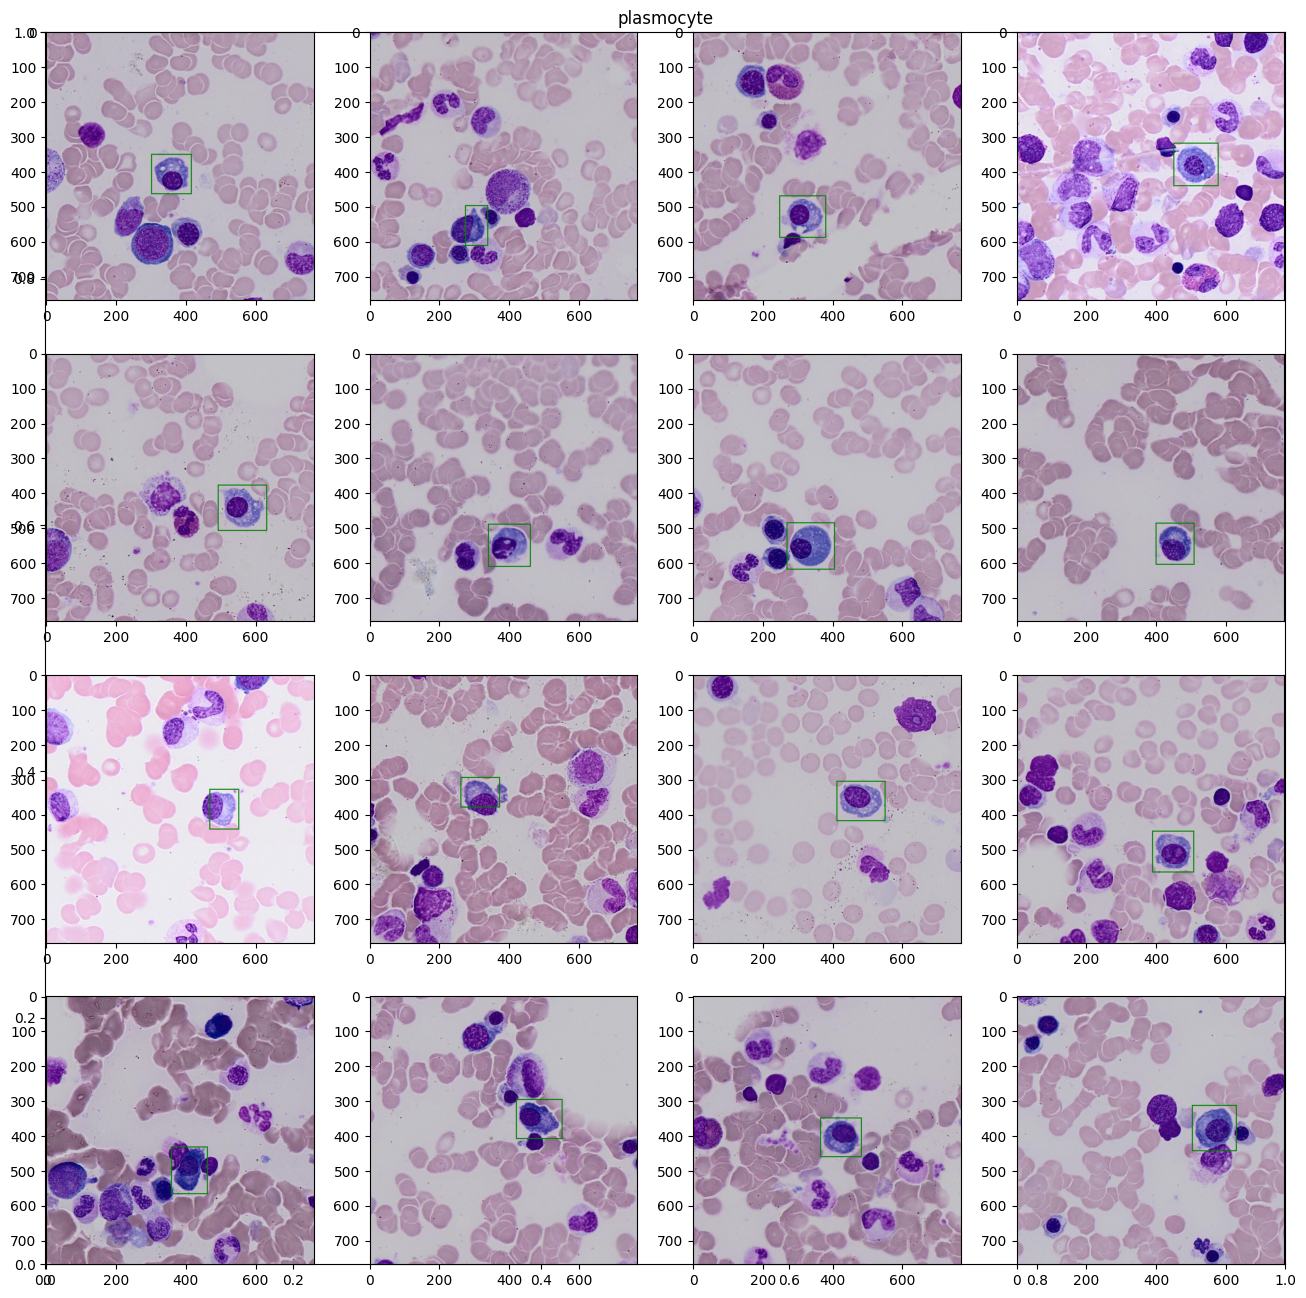

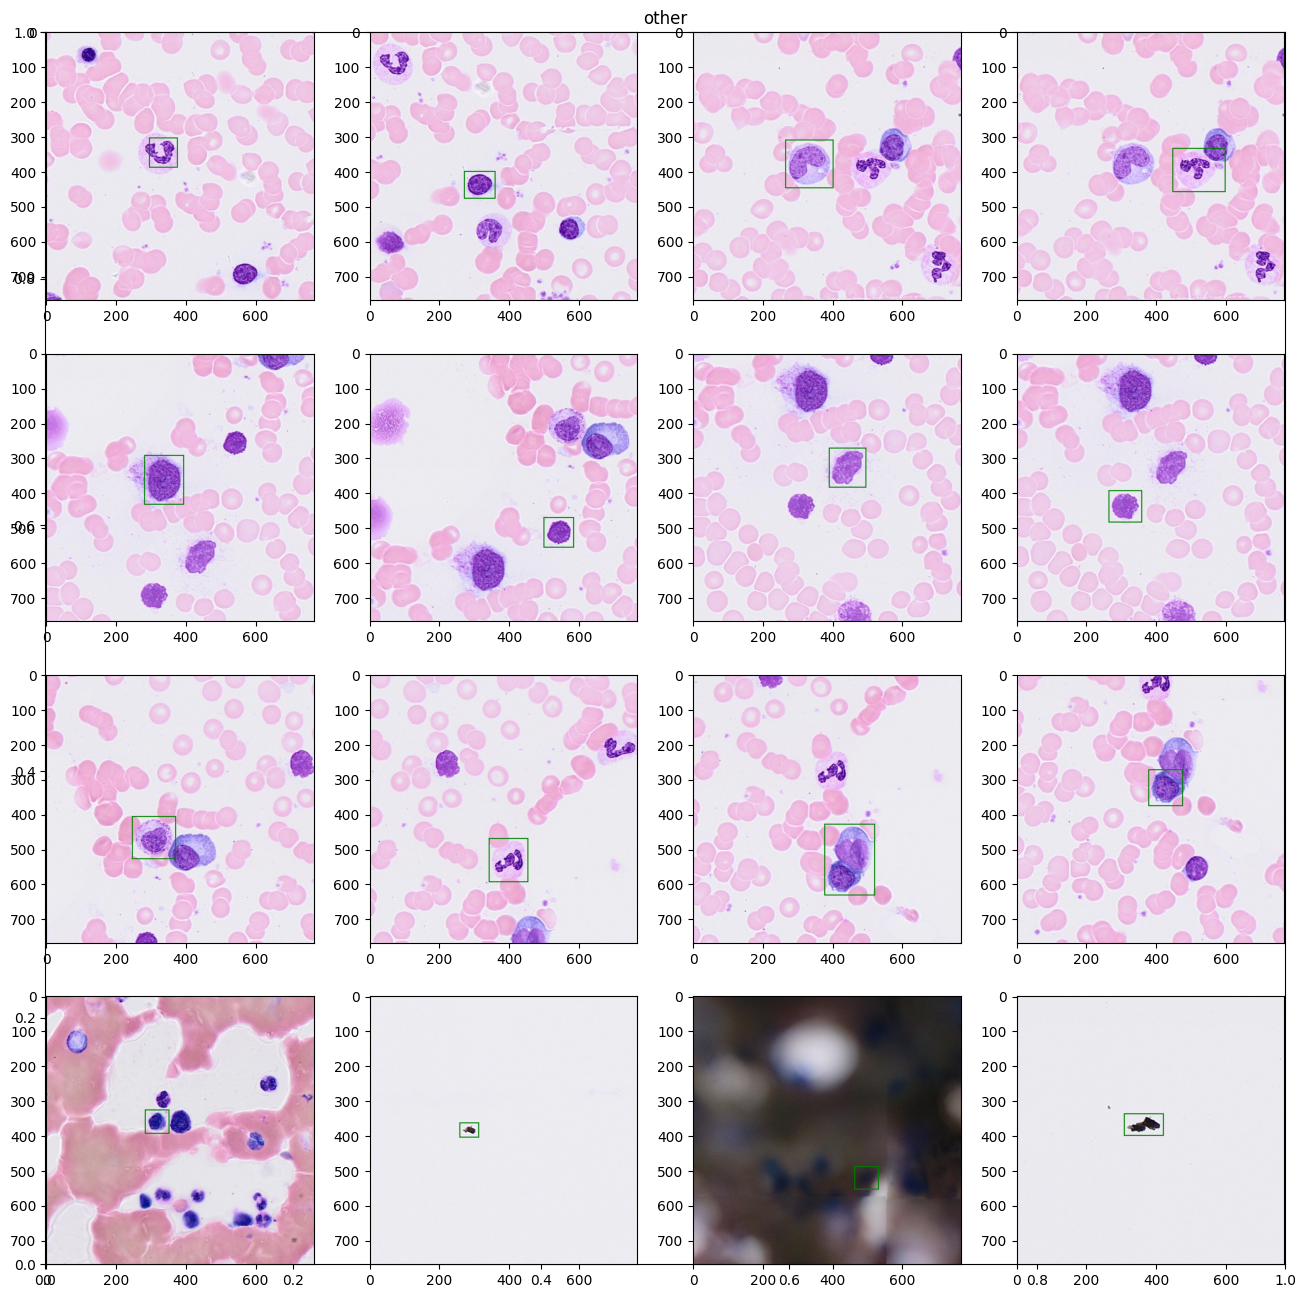

In [ ]:
from pathlib import Path
from PIL import Image, ImageDraw

ROOT = ""

def load_image_with_bbox(bbox, center_crop=False):
    """
    Load a 3x3 composite of tiles around the given bounding box and optionally
    return a 512x512 crop centered on the bounding box.

    Args:
        bbox (list or tuple): [imgnumber, row, col, height, width]
            - imgnumber: The image number (e.g., 5 for 'img5')
            - row, col: Top-left coordinates of the bounding box in global coordinates
            - height, width: Size of the bounding box
        center_crop (bool): If True, return a 512x512 crop centered on the bounding box.
                            If False, return the full 768x768 (3x3 tiles) composite.

    Returns:
        PIL.Image: The assembled image with bounding box drawn.
    """
    # Unpack the bounding box
    imgnumber, bbox_row, bbox_col, bbox_height, bbox_width = bbox

    TILE_SIZE = 256
    COMPOSITE_SIZE = TILE_SIZE * 3  # 768x768
    CROP_SIZE = 512
    HALF_CROP = CROP_SIZE // 2

    # Directory with tiles
    imgname = f"img{imgnumber}"
    tiles_dir = Path(ROOT) / f"dataset/{imgname}/tiles"

    # Determine the tile grid start
    # We find the tile that contains the top-left corner of the bbox
    tile_row_start = (bbox_row // TILE_SIZE) * TILE_SIZE
    tile_col_start = (bbox_col // TILE_SIZE) * TILE_SIZE

    # Create a composite image (3x3 tiles)
    composite_image = Image.new(
        "RGB", (COMPOSITE_SIZE, COMPOSITE_SIZE), (255, 255, 255)
    )

    # Load surrounding 3x3 tiles
    for i, drow in enumerate([-TILE_SIZE, 0, TILE_SIZE]):
        for j, dcol in enumerate([-TILE_SIZE, 0, TILE_SIZE]):
            tile_row = tile_row_start + drow
            tile_col = tile_col_start + dcol
            tile_name = f"tile_{int(tile_row)}_{int(tile_col)}.jpeg"
            tile_path = tiles_dir / tile_name

            if tile_path.exists():
                try:
                    tile_image = Image.open(tile_path)
                    if tile_image.mode != "RGB":
                        tile_image = tile_image.convert("RGB")
                    composite_image.paste(
                        tile_image, (j * TILE_SIZE, i * TILE_SIZE)
                    )
                except Exception as e:
                    # If tile loading fails, use a placeholder
                    placeholder = Image.new(
                        "RGB", (TILE_SIZE, TILE_SIZE), (200, 200, 200)
                    )
                    draw_placeholder = ImageDraw.Draw(placeholder)
                    draw_placeholder.line(
                        (0, 0) + placeholder.size, fill=(150, 150, 150), width=3
                    )
                    draw_placeholder.line(
                        (0, placeholder.size[1], placeholder.size[0], 0),
                        fill=(150, 150, 150),
                        width=3,
                    )
                    composite_image.paste(
                        placeholder, (j * TILE_SIZE, i * TILE_SIZE)
                    )
            else:
                # Missing tile placeholder
                placeholder = Image.new(
                    "RGB", (TILE_SIZE, TILE_SIZE), (200, 200, 200)
                )
                draw_placeholder = ImageDraw.Draw(placeholder)
                draw_placeholder.line(
                    (0, 0) + placeholder.size, fill=(150, 150, 150), width=3
                )
                draw_placeholder.line(
                    (0, placeholder.size[1], placeholder.size[0], 0),
                    fill=(150, 150, 150),
                    width=3,
                )
                composite_image.paste(placeholder, (j * TILE_SIZE, i * TILE_SIZE))

    # Draw the bounding box on the composite image
    # Calculate the bounding box coordinates relative to the composite image
    # The composite image's center tile corresponds to (tile_row_start, tile_col_start) in global coords
    # Top-left tile in composite is at (tile_row_start - TILE_SIZE, tile_col_start - TILE_SIZE)
    composite_top_row = tile_row_start - TILE_SIZE
    composite_left_col = tile_col_start - TILE_SIZE

    bbox_row_rel = bbox_row - composite_top_row
    bbox_col_rel = bbox_col - composite_left_col
    bbox_bottom_rel = bbox_row_rel + bbox_height
    bbox_right_rel = bbox_col_rel + bbox_width

    draw = ImageDraw.Draw(composite_image)
    draw.rectangle(
        [bbox_col_rel-10, bbox_row_rel-10, bbox_right_rel+10, bbox_bottom_rel+10],
        outline="green",
        width=3,
    )

    if center_crop:
        # We want to produce a 512x512 crop centered on the bbox center
        bbox_center_row = bbox_row_rel + bbox_height / 2
        bbox_center_col = bbox_col_rel + bbox_width / 2

        # Center the BBox in the crop
        # The BBox center should map to the center of the crop (256, 256)
        left = int(bbox_center_col - HALF_CROP)
        upper = int(bbox_center_row - HALF_CROP)
        right = left + CROP_SIZE
        lower = upper + CROP_SIZE

        # Ensure we don't go outside the composite image boundaries
        if left < 0:
            right -= left
            left = 0
        if upper < 0:
            lower -= upper
            upper = 0
        if right > COMPOSITE_SIZE:
            left -= right - COMPOSITE_SIZE
            right = COMPOSITE_SIZE
        if lower > COMPOSITE_SIZE:
            upper -= lower - COMPOSITE_SIZE
            lower = COMPOSITE_SIZE

        # Crop the image
        cropped_image = composite_image.crop((left, upper, right, lower))

        # If needed, pad to ensure exactly 512x512
        w, h = cropped_image.size
        if w < CROP_SIZE or h < CROP_SIZE:
            padded = Image.new("RGB", (CROP_SIZE, CROP_SIZE), (255, 255, 255))
            padded.paste(
                cropped_image, ((CROP_SIZE - w) // 2, (CROP_SIZE - h) // 2)
            )
            cropped_image = padded

        return cropped_image
    else:
        return composite_image

import matplotlib.pyplot as plt
for label, class_name in enumerate((*classes , 'other')):
    selection_mask = labels == label
    selected_bboxes = labeled_bboxes[selection_mask]
    sampled_indices = 100+np.arange(16) #np.random.choice(np.arange(len(selected_bboxes)), 16)
    plt.figure(figsize=(16,16))
    plt.title(class_name)
    for fig_ind, sampled_ind in enumerate(sampled_indices):
        plt.subplot(4,4,fig_ind+1)
        plt.imshow(load_image_with_bbox(selected_bboxes[sampled_ind]))
